In [1]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

2024-08-30 21:25:39.728874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 21:25:39.772211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 21:25:39.789657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 21:25:39.837806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 21:25:41.144943: W tensorflow/compiler/tf2

## Input Data

In [3]:
dataset = xr.open_dataset("../data/data_10_2.nc")
dataset

<xarray.Dataset> Size: 295MB
Dimensions:           (samples: 901, time_steps: 2560, channels: 16)
Coordinates:
  * samples           (samples) int64 7kB 0 1 2 3 4 5 ... 896 897 898 899 900
Dimensions without coordinates: time_steps, channels
Data variables:
    signal            (samples, time_steps, channels) float64 295MB ...
    label             (samples) int64 7kB ...
    segment           (samples) int64 7kB ...
    patient_name      (samples) <U8 29kB ...
    recording_number  (samples) int64 7kB ...

In [4]:
df = dataset[["label", "patient_name", "samples"]].to_dataframe()
df.value_counts().sort_index()

label  patient_name
0      amer            110
       dhelal          108
       mahmud           46
       omran            92
1      bader            70
       mohammed        125
       nour             92
       saud             60
       shahad          122
       yahia            76
Name: count, dtype: int64

In [9]:
test_patients = [
    # autism
    "dhelal", "mahmud",
    # normal
    "bader", "mohammed"
]

test_dataset = dataset.sel(samples=df[df["patient_name"].isin(test_patients)].index.tolist())
train_dataset = dataset.sel(samples=df[~df["patient_name"].isin(test_patients)].index.tolist())

X_train = train_dataset["signal"].to_numpy()
y_train = train_dataset["label"].to_numpy()

X_test = test_dataset["signal"].to_numpy()
y_test = test_dataset["label"].to_numpy()

In [10]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([202, 350])), (array([0, 1]), array([154, 195])))

In [7]:
X = dataset["signal"].to_numpy()
y = dataset["label"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [8]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([238, 365])), (array([0, 1]), array([118, 180])))

## Create Model

In [11]:
# input
inputs = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2],))

x = tf.keras.layers.Conv1D(64, kernel_size=8, strides=2, activation="relu", padding="same", use_bias=False)(inputs)
# x = tf.keras.layers.Conv1D(64, kernel_size=4, strides=2, activation="relu", padding="same", use_bias=False)(x)

# classification layer
# x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.3)(x)

# output_bias = tf.keras.initializers.Constant(initial_bias)
# outputs = tf.keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

I0000 00:00:1725027953.364320  276409 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725027953.581756  276409 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725027953.581847  276409 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725027953.584423  276409 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725027953.584500  276409 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2560, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1280, 64)       │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,777 (296.00 KB)

 Trainable params: 75,777 (296.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryFocalCrossentropy(),
    # loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    #   tf.keras.metrics.Precision(name='precision'),
    #   tf.keras.metrics.Recall(name='recall'),
    #   tf.keras.metrics.AUC(name='auc'),
    #   tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])

In [13]:
log_dir = "logs2/" + "cnn1d_chrononet_v1" #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, start_from_epoch=30, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100


I0000 00:00:1725027958.336526  276556 service.cc:146] XLA service 0x7fa38c00b320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725027958.336637  276556 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-08-30 21:25:58.407392: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-30 21:25:58.619561: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5371 - fn: 46.3077 - fp: 46.5769 - loss: 15.6051 - tn: 37.9615 - tp: 85.1538     

I0000 00:00:1725027959.863540  276556 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.5722 - fn: 55.3333 - fp: 58.4444 - loss: 13.2529 - tn: 54.1667 - tp: 127.1667 - val_accuracy: 0.4040 - val_fn: 117.0000 - val_fp: 91.0000 - val_loss: 6.5263 - val_tn: 63.0000 - val_tp: 78.0000
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8810 - fn: 13.6944 - fp: 21.3056 - loss: 0.6091 - tn: 85.6944 - tp: 174.4167 - val_accuracy: 0.3238 - val_fn: 149.0000 - val_fp: 87.0000 - val_loss: 6.5609 - val_tn: 67.0000 - val_tp: 46.0000
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9067 - fn: 14.5000 - fp: 12.1667 - loss: 0.2440 - tn: 93.8056 - tp: 174.6389 - val_accuracy: 0.4699 - val_fn: 62.0000 - val_fp: 123.0000 - val_loss: 4.3669 - val_tn: 31.0000 - val_tp: 133.0000
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9474 - fn: 8.3611 - fp: 7.8056 - loss: 0.1053 - tn: 101.0000 - tp: 177.9444 - val_accuracy: 0.5215 - val_fn: 41.0000 - val_fp: 126.0000 - val_loss: 3.9538 - val_tn: 28.0000 

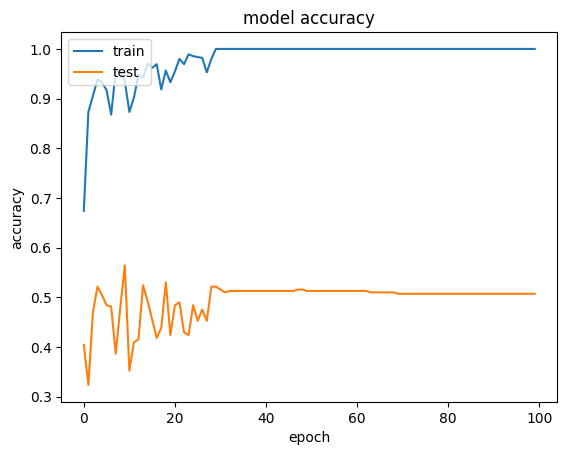

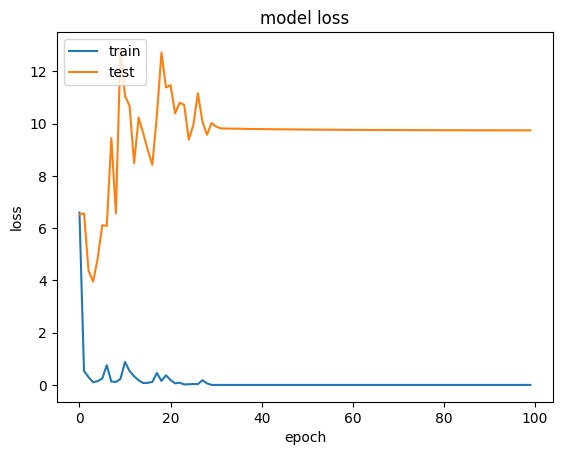

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate

In [15]:
model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7261 - fn: 38.8333 - fp: 33.9167 - loss: 4.9088 - tn: 27.9167 - tp: 104.1667


[9.742595672607422, 135.0, 112.0, 42.0, 60.0, 0.5071633458137512]

In [16]:
y_pred = (model.predict(X_test) > 0.5).astype(int).ravel()

print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MCC: -0.0382
Accuracy: 0.5072
Precision: 0.5466
Recall: 0.6923
F1: 0.6109
              precision    recall  f1-score   support

           0       0.41      0.27      0.33       154
           1       0.55      0.69      0.61       195

    accuracy                           0.51       349
   macro avg       0.48      0.48      0.47       349
weighted avg       0.49      0.51      0.49       349



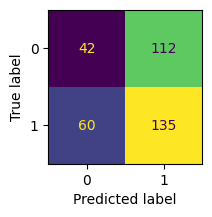

In [17]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)

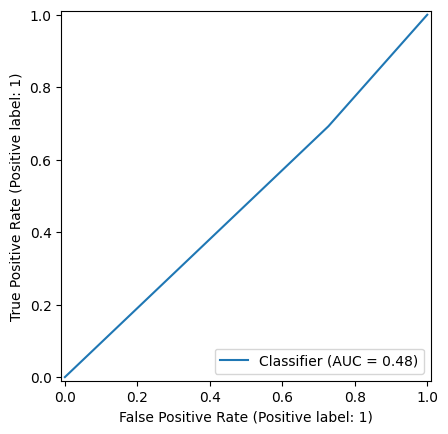

In [18]:
RocCurveDisplay.from_predictions(y_test, y_pred)

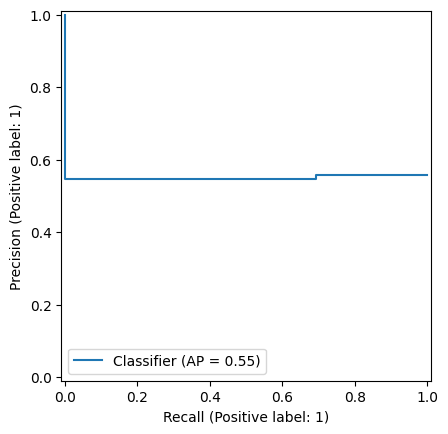

In [19]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

## Coba Prediksi Satu

In [43]:
df = dataset[["label", "patient_name", "samples"]].to_dataframe()
df.value_counts().sort_index()

label  patient_name
0      amer            110
       dhelal          108
       mahmud           46
       omran            92
1      bader            70
       mohammed        125
       nour             92
       saud             60
       shahad          122
       yahia            76
Name: count, dtype: int64

In [56]:
coba_dataset = dataset.sel(samples=df[df["patient_name"] == "dhelal"].index.tolist())
coba_dataset

<xarray.Dataset> Size: 35MB
Dimensions:           (samples: 108, time_steps: 2560, channels: 16)
Coordinates:
  * samples           (samples) int64 864B 793 794 795 796 ... 897 898 899 900
Dimensions without coordinates: time_steps, channels
Data variables:
    signal            (samples, time_steps, channels) float64 35MB 25.53 ... ...
    label             (samples) int64 864B 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    segment           (samples) int64 864B ...
    patient_name      (samples) <U8 3kB 'dhelal' 'dhelal' ... 'dhelal' 'dhelal'
    recording_number  (samples) int64 864B ...

In [57]:
X_coba = coba_dataset["signal"].to_numpy()
y_coba = coba_dataset["label"].to_numpy()
y_pred = (model.predict(X_coba) > 0.5).astype(int).ravel()
y_pred

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

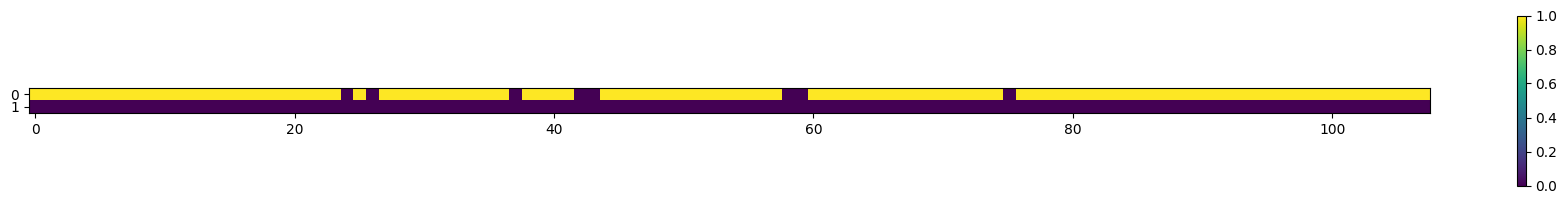

In [58]:
h = np.vstack([y_pred, y_coba])

fig, ax = plt.subplots(figsize=(18, 2))
im = ax.imshow(h)
fig.tight_layout()
fig.colorbar(im)
plt.show()